# **Exercise 1**

## **Installing Dependencies**
```bash
pip install pomegranate==0.14.9


In [1]:
pip install pomegranate==0.14.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for pomegranate: filename=pomegranate-0.14.9-cp310-cp310-linux_x86_64.whl size=18331588 sha256=2feb15fc968a6520786dd9252de26e63cd30b2203804a2e5bca63249d5c2924e
  Stored in directory: /root/.cache/pip/wheels/14/e7/b2/189a2d351ac4ae073cfa17ce9d56936d59af5712a18028fc31
Successfully built pomegranate
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [2]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import torch

Populating the interactive namespace from numpy and matplotlib


## **Part A: Designing the Bayesian Network**

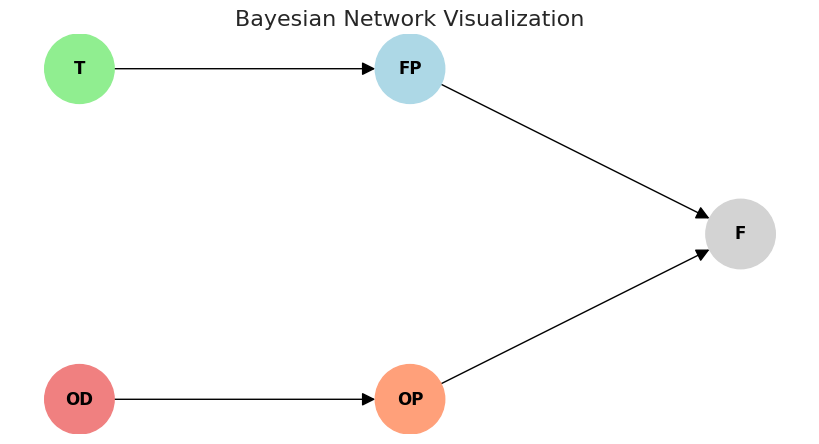

Conditional Probability Tables (CPTs):

Travel:
        Probability
T=No          0.95
T=Yes         0.05

Foreign Purchase given Travel:
           T=No  T=Yes
FP=No   0.9999   0.12
FP=Yes  0.0001   0.88

Owns Device:
         Probability
OD=No           0.3
OD=Yes          0.7

Online Purchase given Owns Device:
         OD=No  OD=Yes
OP=No    0.95     0.6
OP=Yes   0.05     0.4

Fraud given Foreign Purchase and Online Purchase:
        FP=No, OP=No  FP=No, OP=Yes  FP=Yes, OP=No  FP=Yes, OP=Yes
F=No           0.25           0.15            0.2           0.005
F=Yes          0.75           0.85            0.8           0.995


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import pomegranate as pom

F = 'Fraud'
T = 'Travel'
OD = 'OwnsDevice'
FP = 'ForeignPurchase'
OP = 'OnlinePurchase'

# travel distribution
travel_distribution = pom.DiscreteDistribution({False: 0.05, True: 0.95})

# foreign purchase given travel distribution
foreign_purchase_distribution = pom.ConditionalProbabilityTable(
    [
        [False, False, 0.9999],
        [False, True, 0.0001],
        [True, False, 0.12],
        [True, True, 0.88]
    ],
    [travel_distribution])

# owns device distribution
owns_device_distribution = pom.DiscreteDistribution({False: 0.3, True: 0.7})

# online purchase given owns device distribution
online_purchase_distribution = pom.ConditionalProbabilityTable(
    [
        [False, False, 0.95],
        [False, True, 0.05],
        [True, False, 0.60],
        [True, True, 0.40]
    ],
    [owns_device_distribution])

# fraud given online purchase and foreign purchase distribution
fraud_distribution = pom.ConditionalProbabilityTable(
    [
        [False, False, False, 0.25],
        [False, True, False, 0.15],
        [True, False, False, 0.20],
        [True, True, False, 0.005],
        [False, False, True, 0.75],
        [False, True, True, 0.85],
        [True, False, True, 0.80],
        [True, True, True, 0.995]
    ],
    [online_purchase_distribution, foreign_purchase_distribution])

# Nodes creation for Bayesian Network
foreign_purchase = pom.Node(foreign_purchase_distribution, name=FP)
online_purchase = pom.Node(online_purchase_distribution, name=OP)
fraud = pom.Node(fraud_distribution, name=F)
owns_device = pom.Node(owns_device_distribution, name=OD)
travel = pom.Node(travel_distribution, name=T)

# Bayesian Network creation
model = pom.BayesianNetwork("Fraud Detection")
model.add_states(fraud, owns_device, travel, foreign_purchase, online_purchase)

# Dependencies between Nodes though add directed edges
model.add_edge(travel, foreign_purchase)
model.add_edge(owns_device, online_purchase)
model.add_edge(foreign_purchase, fraud)
model.add_edge(online_purchase, fraud)
model.bake()

# Define conditional probability tables with more details
cpt_travel = pd.DataFrame({'Probability': [0.95, 0.05]}, index=['T=No', 'T=Yes'])
cpt_foreign_purchase = pd.DataFrame({'T=No': [0.9999, 0.0001],
                                     'T=Yes': [0.12, 0.88]}, index=['FP=No', 'FP=Yes'])
cpt_owns_device = pd.DataFrame({'Probability': [0.3, 0.7]}, index=['OD=No', 'OD=Yes'])
cpt_online_purchase = pd.DataFrame({'OD=No': [0.95, 0.05],
                                    'OD=Yes': [0.6, 0.4]}, index=['OP=No', 'OP=Yes'])
cpt_fraud = pd.DataFrame({'FP=No, OP=No': [0.25, 0.75],
                          'FP=No, OP=Yes': [0.15, 0.85],
                          'FP=Yes, OP=No': [0.2, 0.8],
                          'FP=Yes, OP=Yes': [0.005, 0.995]},
                         index=['F=No', 'F=Yes'])

# Create directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(['T', 'FP', 'OD', 'OP', 'F'])

# Add edges
G.add_edges_from([('T', 'FP'),
                  ('OD', 'OP'),
                  ('FP', 'F'),
                  ('OP', 'F')])

# Manually set the positions for each node for better alignment and visualization
pos = {
    'T': (0, 1),  # Travel at the top
    'FP': (1, 1),  # Foreign Purchase to the right of Travel
    'OD': (0, 0),  # Owns Device at the bottom left
    'OP': (1, 0),  # Online Purchase to the right of Owns Device, at the bottom
    'F': (2, 0.5)  # Fraud to the right of Foreign Purchase and Online Purchase, centered vertically
}

# Draw the graph with manually set positions
plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True, node_size=2500, node_color=['lightgreen', 'lightblue', 'lightcoral', 'lightsalmon', 'lightgray'],
        font_size=12, font_weight='bold', arrowsize=20)

plt.title("Bayesian Network Visualization", fontsize=16)
plt.axis('off')  # Turn off the axis
plt.show()

# Print conditional probability tables more beautifully
print("Conditional Probability Tables (CPTs):")
print("\nTravel:\n", cpt_travel.to_string())
print("\nForeign Purchase given Travel:\n", cpt_foreign_purchase.to_string())
print("\nOwns Device:\n", cpt_owns_device.to_string())
print("\nOnline Purchase given Owns Device:\n", cpt_online_purchase.to_string())
print("\nFraud given Foreign Purchase and Online Purchase:\n", cpt_fraud.to_string())


## **Part B: Inference in Bayesian Network**

In [4]:
N = 10000

# Variable Elimination to find probabilities under different evidences

#Time Complexity : O(d^k); d = largest domain size

print("Using Variable Elimination:\n")

# No evidence
no_evidence = model.predict_proba({})
prob_fraud_no_evidence = no_evidence[model.states.index(fraud)].parameters[0][True]

# Evidence: OwnsDevice = True
evidence_owns_device = {OD: True}
prob_fraud_owns_device = model.predict_proba(evidence_owns_device)[model.states.index(fraud)].parameters[0][True]

# Evidence: OwnsDevice = True, Travel = True
evidence_owns_device_and_travels = {OD: True, T: True}
prob_fraud_owns_device_and_travels = model.predict_proba(evidence_owns_device_and_travels)[model.states.index(fraud)].parameters[0][True]

print("Query (a): Probability of Fraud with no evidence (V.E.M):", prob_fraud_no_evidence)
print("Query (b): Probability of Fraud with evidence that the person owns a device (V.E.M):", prob_fraud_owns_device)
print("Query (c): Probability of Fraud with evidence that the person owns a device and travels (V.E.M):", prob_fraud_owns_device_and_travels)

print("\n----------------------------------------------------------------------------------------------------------------------------\n")
print("Using Gibbs Sampling:\n")

# Gibbs Sampling

#Time Complexity : O(n*t);  n: no.of random variables,

# No evidence
predictions_gibbs_no_evidence = model._gibbs(n=N, evidences=[{}])
prob_fraud_no_evidence_gibbs = len(list(filter(lambda x: x[0], predictions_gibbs_no_evidence))) / N
print("Query (a): Probability of Fraud with no evidence (Gibbs Sampling):", prob_fraud_no_evidence_gibbs)

# Evidence: OwnsDevice = True
predictions_gibbs_owns_device = model._gibbs(n=N, evidences=[{OD: True}])
prob_fraud_owns_device_gibbs = len(list(filter(lambda x: x[0], predictions_gibbs_owns_device))) / N
print("Query (b): Probability of Fraud with evidence that the person owns a device (Gibbs Sampling):", prob_fraud_owns_device_gibbs)

# Evidence: OwnsDevice = True, Travel = True
predictions_gibbs_abroad = model._gibbs(n=N, evidences=[{OD: True, T: True}])
prob_fraud_abroad_gibbs = len(list(filter(lambda x: x[0], predictions_gibbs_abroad))) / N
print("Query (c): Probability of Fraud with evidence that the person owns a device and travels (Gibbs Sampling):", prob_fraud_abroad_gibbs)


Using Variable Elimination:

Query (a): Probability of Fraud with no evidence (V.E.M): 0.8717795401249998
Query (b): Probability of Fraud with evidence that the person owns a device (V.E.M): 0.8853686899999998
Query (c): Probability of Fraud with evidence that the person owns a device and travels (V.E.M): 0.8914399999999999

----------------------------------------------------------------------------------------------------------------------------

Using Gibbs Sampling:

Query (a): Probability of Fraud with no evidence (Gibbs Sampling): 0.8696
Query (b): Probability of Fraud with evidence that the person owns a device (Gibbs Sampling): 0.882
Query (c): Probability of Fraud with evidence that the person owns a device and travels (Gibbs Sampling): 0.8915
